In [1]:
!pip install deepxde

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.io import loadmat
from mpl_toolkits.mplot3d import axes3d
import pickle

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



# Formulation of the Problem
Our goal is to estimate $\frac{\lambda+\mu}{\mu}$ of the vector wave equation, given the dataset of $u$ and $w$. The formulation can be written as follows:

\begin{align}
\frac{\partial^2 u}{\partial\tau^2} = \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) + \left(\frac{\lambda+\mu}{\mu}\right)\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 w}{\partial x \partial y}\right)\\
\frac{\partial^2 w}{\partial\tau^2} = \left(\frac{\partial^2 w}{\partial x^2} + \frac{\partial^2 w}{\partial y^2}\right) + \left(\frac{\lambda+\mu}{\mu}\right)\left(\frac{\partial^2 u}{\partial x \partial y} + \frac{\partial^2 w}{\partial y^2}\right)
    \end{align}

The true value of $\frac{\lambda+\mu}{\mu}$ is $\frac{50+30}{30} = 2.667$.

In [3]:
# Import .mat file
data = loadmat('vector_2nd.mat')
u = data['u_log'].transpose(1, 0, 2)
w = data['v_log'].transpose(1, 0, 2)
tspan = data['tspan']

In [4]:
x = np.arange(0, 1.01, 0.01)  # Equidistant spacing from 0 to 1 with step size 0.01
y = np.arange(0, 1.01, 0.01)  # Equidistant spacing from 0 to 1 with step size 0.01
t = tspan.reshape(-1)  # Equidistant spacing from 0 to 0.001 with step size 0.0001

# Get indices of every 10 points in space and every time step
x_indices = np.arange(0, len(x), 10)
y_indices = np.arange(0, len(y), 5)
t_indices = np.arange(0, len(t), 1)

# Create meshgrid using every 10 points in space and every time step
xv, yv, tv = np.meshgrid(x[x_indices], y[y_indices], t[t_indices])
xyt_train = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1), tv.reshape(-1,1)))

u_train = u[x_indices[:, None, None], y_indices[None, :, None], t_indices[None, None, :]].reshape(-1,1)
w_train = w[x_indices[:, None, None], y_indices[None, :, None], t_indices[None, None, :]].reshape(-1,1)

print(xyt_train.shape, u_train.shape)

observe_u = dde.icbc.PointSetBC(xyt_train, u_train, component=0)
observe_w = dde.icbc.PointSetBC(xyt_train, w_train, component=1)

(23331, 3) (23331, 1)


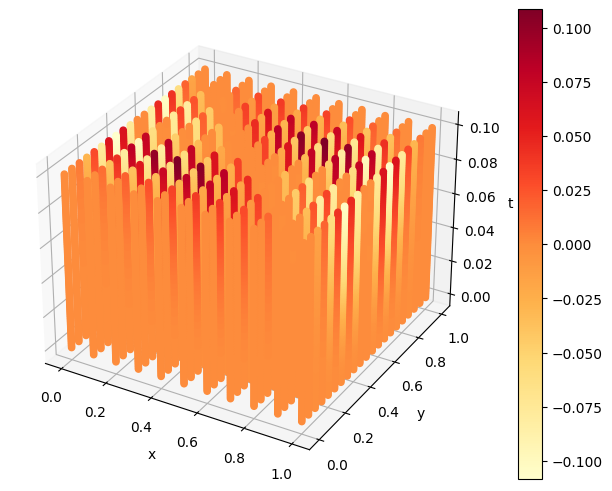

In [5]:
plt.rcParams["figure.figsize"] = [8.00, 5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(xv, yv, tv, c= w_train , cmap='YlOrRd', alpha=1)
fig.colorbar(img)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()

In [6]:
# Specify parameters lambda, mu
lamb = 50
mu = 30
Ctrue = (lamb+mu)/mu
print(Ctrue)

# Define initial guess for rho
C = dde.Variable(2.0)

2.6666666666666665


In [7]:
def pde(x, y):
    '''Define a system of PDE to be used as loss function
      Input  x: input neurons representing (x, y, t)
              y: output from neuron network (u, w)

      Return a list of equations to be used in loss function'''

    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    du_xy = dde.grad.hessian(y, x, component=0, i=0, j=1)
    du_tt = dde.grad.hessian(y, x, component=0, i=2, j=2)

    dw_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dw_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    dw_xy = dde.grad.hessian(y, x, component=1, i=0, j=1)
    dw_tt = dde.grad.hessian(y, x, component=1, i=2, j=2)

    return [- du_tt + (du_xx + du_yy) + C*(du_xx + dw_xy),
            - dw_tt + (dw_xx + dw_yy) + C*(dw_yy + du_xy)]

def get_initial_loss(model):
    # get loss of the first iteration to weight the loss function
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]

# Neural Network Setup and Train Model

Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 16.439769 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.84e+05, 1.81e+05, 1.50e-01, 9.31e-02]    [1.73e+05, 1.73e+05, 1.50e-01, 9.31e-02]    []  

Best model at step 0:
  train loss: 3.64e+05
  test loss: 3.46e+05
  test metric: []

'train' took 9.827126 s

Compiling model...
'compile' took 4.522753 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.34e+00, 1.43e+01, 5.46e+00, 4.30e+00]    [5.21e+00, 1.30e+01, 5.46e+00, 4.30e+00]    []  
500       [2.72e-02, 1.08e-02, 5.19e-01, 2.82e-02]    [5.23e-01, 2.02e-01, 5.19e-01, 2.82e-02]    []  
1000      [4.96e-02, 1.96e-02, 6.44e-02, 2.68e-02]    [5.55e+00, 1.68e+00, 6.44e-02, 2.68e-02]    []  
1500      [1.38e-02, 1.26e-02, 2.68e-02, 2.14e-02]    [8.55e+00, 2.28e+00, 2.68e-02, 2.14e-02]    []  
2000      [5.83e-03, 8.23e-03, 1.74e-02, 

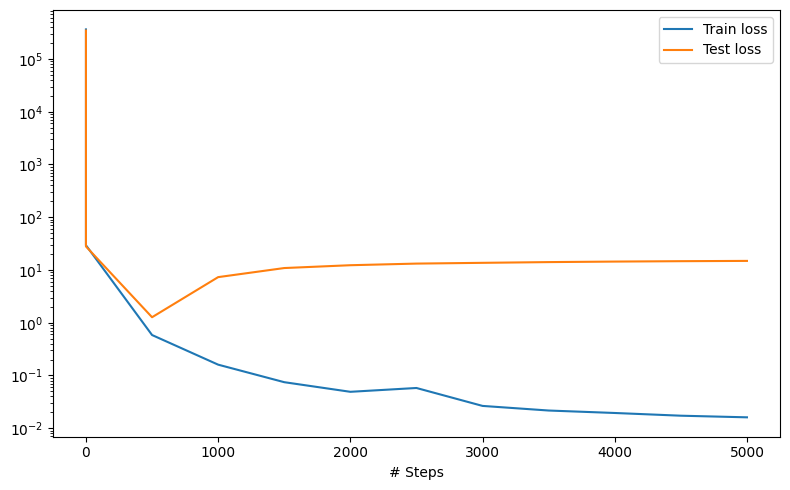

In [8]:
# Spatial domain: X × Y = [0, 1] × [0, 1]
Lx_min, Lx_max = 0.0, 1.0
Ly_min, Ly_max = 0.0, 1.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# Time domain: T = [0, 0.001]
time_domain = dde.geometry.TimeDomain(0.0, 0.1)

# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_u, observe_w],
    num_domain=700,
    num_test=10000,
    anchors=xyt_train,
)

layer_size = [3] + [100] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.STMsFFN(
    layer_size, activation, initializer, sigmas_x=[1, 5], sigmas_t=[1, 5]
)
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))

model = dde.Model(data, net)
initial_losses = get_initial_loss(model)
loss_weights = 5 / initial_losses

model.compile(
    "adam",
    lr=0.001,
    loss_weights=loss_weights,
    decay=("inverse time", 2000, 0.9),
    external_trainable_variables=[C],
)
pde_residual_resampler = dde.callbacks.PDEPointResampler(period=1, pde_points=True, bc_points=True)

fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C], period=100, filename=fnamevar)

losshistory, train_state = model.train(
    iterations=5000, callbacks=[pde_residual_resampler, variable], display_every=500
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Predict Solution

In [9]:
# Define the prediction domain
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 0.1, 101)
xv, yv, tv = np.meshgrid(x, y, t)

x_test = xv.flatten()[:,None]
y_test = yv.flatten()[:,None]
t_test = tv.flatten()[:,None]
ob_xyt = np.hstack((x_test, y_test, t_test))

# Predict the solutions
pred = model.predict(ob_xyt)

with open('objs.pkl', 'wb') as f:
    pickle.dump(pred, f)
